In [24]:
#**THIS SHEET CONTAINS WEBSCRAPING, CLEANING AND CLUSTERING TO MAKE MARKING EASIER**

# !pip install beautifulsoup4
!pip install lxml
!pip install geopy
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
### Tips for  Webscraping Updated Table in Week3 Peer Graded Assignmen

source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [4]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [5]:
df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
print("Shape: ", df.shape)

Shape:  (103, 3)


In [7]:
# Dropping the rows where Borough is 'Not assigned'
df1 = df[df.Borough != 'Not assigned']

In [8]:
df2 = df1.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

In [9]:
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned',df2['Borough'], df2['Neighborhood'])

df2

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [10]:
df2.rename(columns={'Postal Code':'Postcode'},inplace=True)


In [11]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
lat_lon.rename(columns={'Postal Code':'PostalCode'},inplace=True)
lat_lon.head()


,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
df3 = pd.merge(df2,lat_lon,on='PostalCode')
df3.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [23]:
## **The notebook from here includes the Clustering and the plotting of the neighbourhoods of Canada which contain Toronto in their Borough**

In [15]:
df4 = df3[df3['Borough'].str.contains('Toronto',regex=False)]
df4

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
40,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [17]:
map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(df4['Latitude'],df4['Longitude'],df4['Borough'],df4['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

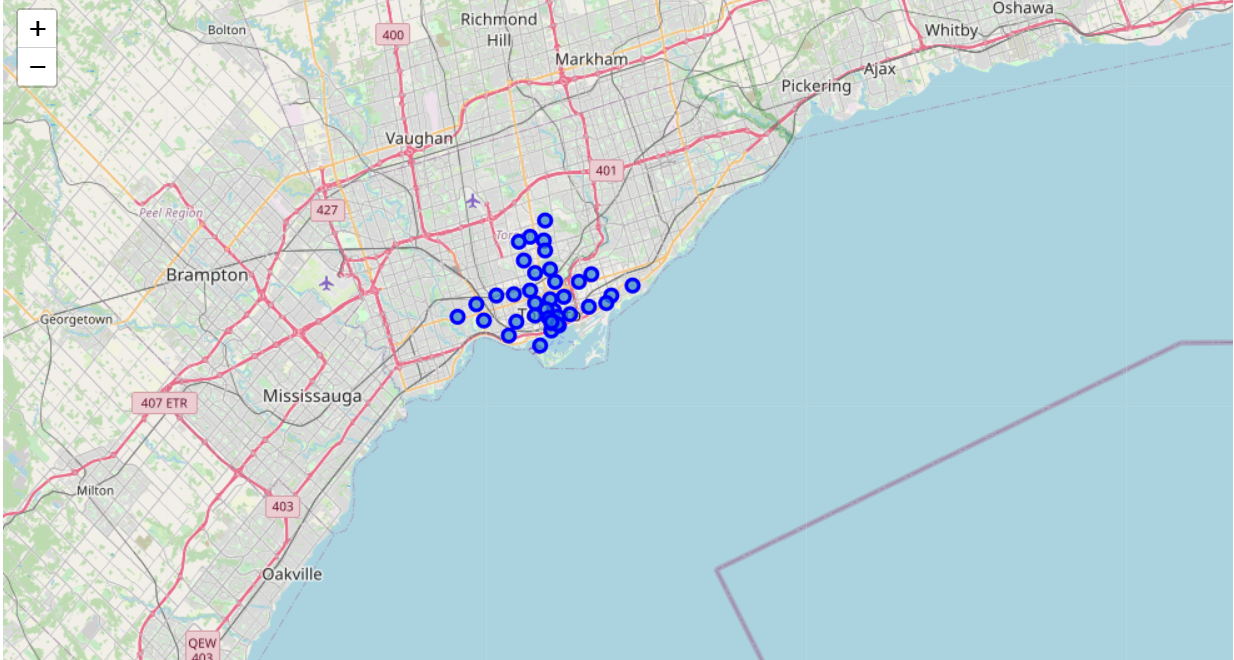

## **Using KMeans clustering for the clsutering of the neighbourhoods**

In [18]:
k=5
toronto_clustering = df4.drop(['PostalCode','Borough','Neighborhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
kmeans.labels_
df4.insert(0, 'Cluster Labels', kmeans.labels_)

In [19]:
df4

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,0,M4E,East Toronto,The Beaches,43.676357,-79.293031
40,0,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
41,0,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,0,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,0,M4M,East Toronto,Studio District,43.659526,-79.340923
44,2,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,2,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,2,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,2,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [21]:
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df4['Latitude'], df4['Longitude'], df4['Neighborhood'], df4['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

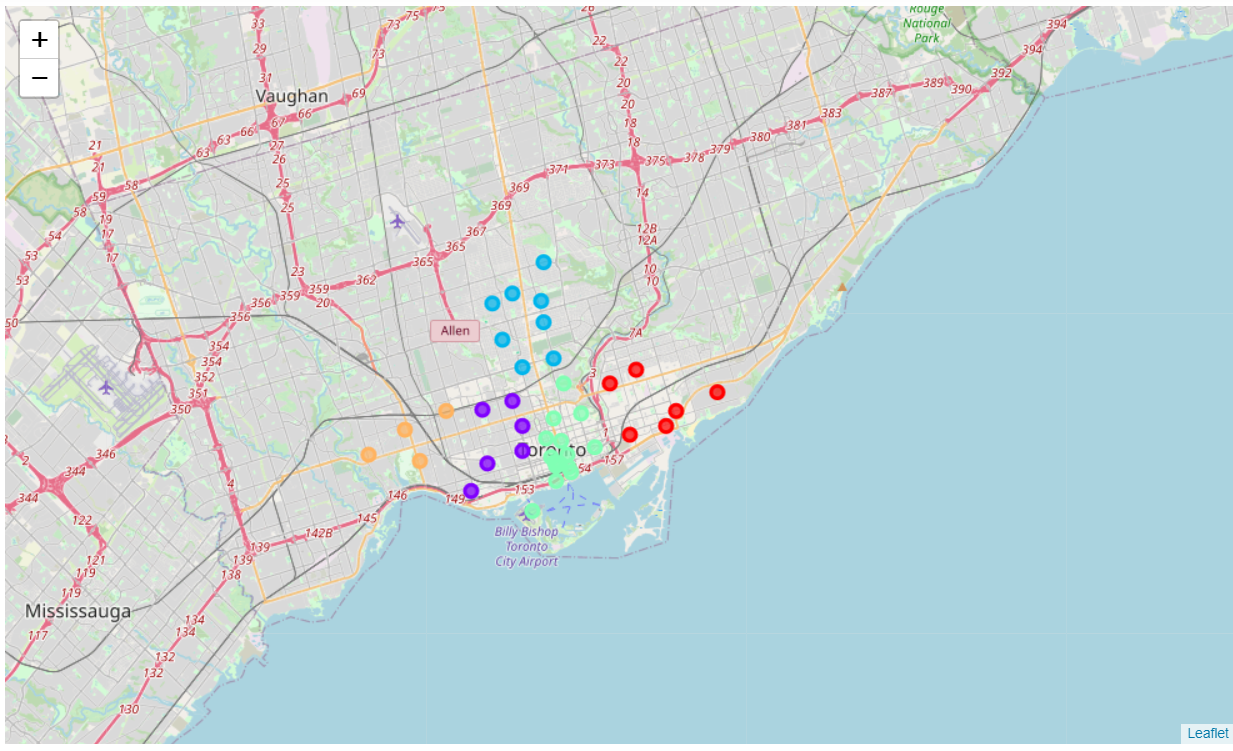